# ALGO-TRADING FRAMEWORK WITH LSTMS

The goal of this project is to present a pipeline for predicting stocks with LSTM-based deep learning models. I demonstrate how to predict the AAPL stock with models which raise in complexity, up to a CNN-LSTM architecture. The prediction is of the adjusted closing price of the next day, based on the prices in the previous 60 days.

# Information

## Bibliography

**Algo-trading reviews - no reinforcement learning**

A survey on machine learning for stock price prediction: algorithms and techniques

http://dx.doi.org/10.5220/0009340700630071
https://www.scitepress.org/Papers/2020/93407/93407.pdf

Algorithmic Trading and Financial Forecasting Using Advanced Artificial Intelligence Methodologies

https://doi.org/10.3390/math10183302

Deep Learning for Stock Market Prediction

https://doi.org/10.3390/e22080840

\

**Algo-trading reviews**

Stock Market Prediction via Deep Learning Techniques: A Survey

https://arxiv.org/abs/2212.12717

An Overview of Machine Learning, Deep Learning, and Reinforcement Learning-Based Techniques in Quantitative Finance: Recent Progress and Challenges

https://doi.org/10.3390/app13031956

Deep Reinforcement Learning in Quantitative Algorithmic Trading: A Review

https://arxiv.org/abs/2106.00123

\

**Sequence models**

Comparative Study of Machine Learning Models for Stock Price Prediction

https://arxiv.org/abs/2202.03156

A CNN-LSTM-Based Model to Forecast Stock Prices

https://doi.org/10.1155/2020/6622927

A CNN–LSTM model for gold price time-series forecasting

https://doi.org/10.1007/s00521-020-04867-x

Evaluation of bidirectional LSTM for short-and long-term stock market prediction

https://doi.org/10.1109/IACS.2018.8355458

Predicting stock market index using LSTM

https://doi.org/10.1016/j.mlwa.2022.100320

## Variables hierarchy

- data_original: symbol -> dataframe with ['Timedate', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

- data_preprocessed: symbol -> train/test -> feature type (from data_original dataframes columns)

- data_feats_and_targets: symbol -> feature type -> train/test -> features/targets -> samples (num_samples X num_time_steps X 1)

    E.g.: data_feats_and_targets['AAPL']['Adj Close']['train']['features'].shape = (1000, 60, 1)

# Initialization

## Installing modules

In [1]:
# !pip install yfinance

## Importing modules

In [2]:
# Math
import math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Datasets
import yfinance as yf

# Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import tensorflow as tf
import keras
from keras.models import Sequential, Model # Sequential & functional APIs
from keras.layers import InputLayer, Input, Activation, Reshape, Flatten, concatenate
from keras.layers import Dense, LSTM, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from tensorflow.keras.utils import plot_model
from keras.models import save_model, load_model
# tf.config.run_functions_eagerly(True)

# File management
import os
import sys
import pickle

# Misc.
import copy
import warnings
# warnings.filterwarnings('ignore')

## Working directory settings

In [3]:
# Working directory settings
is_runtime_local = False # True for local runtime, False for a hosted runtime on Google Colab
working_dir_local = "C:/Sergey\'s Google Drive/Colab Notebooks/Portfolio - Algo-trading/01-Algo_trading_framework_with_LSTMs/"
working_dir_hosted = "/content/drive/My Drive/Colab Notebooks/Portfolio - Algo-trading/01-Algo_trading_framework_with_LSTMs/"

Connecting to local runtime command:

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [4]:
# Setting working directory
if is_runtime_local:
    os.chdir(working_dir_local)

else:
    from google.colab import drive # !pip install google-colab
    drive.mount('/content/drive')
    os.chdir(working_dir_hosted)

working_directory = os.getcwd()
print('Current working directory:')
print(working_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory:
/content/drive/My Drive/Colab Notebooks/Portfolio - Algo-trading/01-Algo_trading_framework_with_LSTMs


## Data settings

In [5]:
# Data settings

# Sections
data_download_flag = False
data_save_flag = False
data_load_flag = True

# Symbols
data_symbols = ['AAPL']
# data_symbols = sorted(['AAPL','SPY'])
# data_symbols = sorted(['SPY','VOO']) # S&P 500 EFT symbols: SPY, VOO, IVV
data_symbol_eg = data_symbols[0] # Example symbol for exploring data

# Time
data_download_by_weeks = False # Use for data which can only be downloaded per one week
data_time_interval = '1d'
data_num_days = 365*5 # For SPY, the requested dates range must be within the last 30 days, so use 29
data_today_date = pd.to_datetime('today').date()

data_end_date = data_today_date
data_start_date = (data_end_date - pd.DateOffset(days=data_num_days)).date()
print(f'Chosen date range:\n[data_start_date, data_end_date] = [{data_start_date}, {data_end_date}]')

# Preprocessing
data_features_names = ['Adj Close','Close','High','Low','Open','Volume']

data_lookback_steps = 60
data_forecast_steps = 1

data_train_test_split = 0.8

# Paths
data_saving_directory = working_directory + '/' + 'Data/'
data_saving_file_name = 'data_' + f'{data_symbols}_'.replace("'","") + f'{data_time_interval}' + '.sav'

data_loading_directory = working_directory + '/' + 'Data/'
data_loading_file_name = data_saving_file_name

Chosen date range:
[data_start_date, data_end_date] = [2018-03-07, 2023-03-06]


## Features & targets settings

In [6]:
# Features and targets settings

# Preprocessing
data_denoise_rolling_flag = False
data_denoise_rolling_steps = 5
data_denoise_fft_flag = True
data_denoise_fft_psd_th_percent = 1e-5

## Machine learning settings

In [7]:
# Machine learning settings

# Sections
ml_run_lstm_single = True
ml_run_lstm_deep = True
ml_run_lstm_bidir = True
ml_run_lstm_bidir_deep = True
ml_run_lstm_cnn = True
ml_run_lstm_cnn_prices_indics = False

ml_train_flag = True
ml_save_flag = True
ml_load_flag = True

# Paths
simulation_id = '230306'
evaluation_saving_path = \
    f'Evaluations/evaluation_{data_symbol_eg}_{data_time_interval}_{simulation_id}.csv'.replace("'","")
print(f'Saving evaluations to:\n{evaluation_saving_path}\n')

Saving evaluations to:
Evaluations/evaluation_AAPL_1d_230306.csv



## Exploration settings

In [8]:
# Exploratory data analysis settings
explore_data_flag = True

# Display
pd.set_option('display.width', 500) # For presenting full dataframes
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)
font_size = 16
tick_size = font_size - 2

## Randomization settings

In [9]:
# Randomization settings
use_fixed_random_seed_flag = True # Fix the randomization seed for reproducibility
random_seed_value = 0

In [10]:
# Applying randomization settings
if use_fixed_random_seed_flag:
    # Choose seed value
    # random_seed_value = 0 # You may use different seed values at each stage

    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED'] = str(random_seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(random_seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(random_seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    # tf.random.set_seed(random_seed_value)

    # For later versions: 
    tf.compat.v1.set_random_seed(random_seed_value)

    # 5. Configure a new global `tensorflow` session
    from keras import backend as K
    # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    # K.set_session(sess)

    # For later versions:
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

# Data

## Collecting data

### Functions

In [11]:
def load_data(symbols, data_time_interval, data_start_date, data_end_date, download_by_weeks, show_info):
    ''' Loading stock prices data from Yahoo finance. '''

    data = {k:pd.DataFrame() for k in symbols}
    for symbol in symbols:
        if download_by_weeks:
            # Creating a dataframe with consecutive time ranges of one week durations
            start_dates = pd.date_range(start=data_start_date, end=data_end_date, freq="7D")
            end_dates = start_dates.shift(6, freq="d")
            # Verifying the latest end_date doesn't go over the specified end_date,
            # since end_dates is a shifted start_dates and might do so
            end_dates = list(end_dates)[:-1] + [min(end_dates[-1], pd.Timestamp(data_end_date))]
            dates = pd.DataFrame(data = {"start_date": start_dates, "end_date": end_dates},
                                columns = ("start_date", "end_date")
                                )
            if show_info:
                print('Dates:\n', dates,'\n')

            dfs_list = [] # Will contain a dataframe per each week
            for i in dates.index:
                start = dates.at[i, "start_date"]
                end = dates.at[i, "end_date"]
                df = yf.download(symbol, start=start, end=end, interval=data_time_interval)
                dfs_list.append(df)
            print()
            data[symbol] = pd.concat(dfs_list).reset_index().rename(columns={'Date': 'Datetime'})

        else:
            data[symbol] = yf.download(symbol, start=data_start_date, end=data_end_date, interval=data_time_interval) \
                            .reset_index().rename(columns={'Date': 'Datetime'})
            print()

    if show_info:
        symbol_eg = symbols[0]
        print(f'Data example - {symbol_eg}:\n')
        print(data[symbol_eg].head(),'\n')

    return data

### Calculation

In [12]:
# Collecting data

# Downloading data
if data_download_flag:
    data_original = load_data(data_symbols, data_time_interval, data_start_date, data_end_date,
                              data_download_by_weeks, show_info=True)

# Saving data
if data_download_flag and data_save_flag:
    saving_path = data_saving_directory + data_saving_file_name
    print('Saving data to:')
    print(saving_path, '\n')
    
    # Saving in pickle format
    if not os.path.exists(data_saving_directory):
        os.makedirs(data_saving_directory)
    pickle.dump(data_original, open(saving_path, 'wb'))

# Loading data
if data_load_flag:
    loading_path = data_loading_directory + data_loading_file_name
    print('Loading data from:')
    print(loading_path, '\n')

    data_original = pickle.load(open(loading_path, 'rb'))
    print(f'Loaded data example - {data_symbol_eg}:\n')
    print(data_original[data_symbol_eg].head(),'\n')

Loading data from:
/content/drive/My Drive/Colab Notebooks/Portfolio - Algo-trading/01-Algo_trading_framework_with_LSTMs/Data/data_[AAPL]_1d.sav 

Loaded data example - AAPL:

    Datetime       Open       High        Low      Close  Adj Close     Volume
0 2018-03-05  43.802502  44.435001  43.630001  44.205002  42.141560  113605600
1 2018-03-06  44.477501  44.562500  44.032501  44.167500  42.105808   95154000
2 2018-03-07  43.735001  43.962502  43.567501  43.757500  41.714943  126814000
3 2018-03-08  43.869999  44.279999  43.767502  44.235001  42.170158   95096400
4 2018-03-09  44.490002  45.000000  44.347500  44.994999  42.894684  128740800 



## Exploring data

### Functions

In [13]:
def explore_data_prices(data, show_info, show_example_data, plot_candlesticks, plot_signals):
    # Presenting general information
    if show_info:
        print('Presenting general information:\n')
        print(data.info(), '\n')
        print(data.describe(), '\n')

    # Presenting example data
    if show_example_data:
        print('Presenting example data:\n')
        print(data.head(5), '\n')

    # Plotting candlesticks
    if plot_candlesticks:
        fig = go.Figure(
            data = [go.Candlestick(x=data['Datetime'],
                                   open=data['Open'],
                                   high=data['High'],
                                   low=data['Low'],
                                   close=data['Close'])])
        fig.update_layout(
            title='Stock Prices',
            xaxis_title='Date',
            yaxis_title='Price [$]'
            )
        fig.show(renderer='colab')
        print()

    # Plotting signals
    if plot_signals:
        columns_to_plot = ['Adj Close','Close','High','Low','Open','Volume']
        fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 40))
        for i in range(0,len(columns_to_plot)):
            axes[i].plot(data[columns_to_plot[i]])
            axes[i].set_title(f'Stock data - {columns_to_plot[i]}')
            axes[i].set_xlabel('Date')
            axes[i].set_ylabel(f'{columns_to_plot[i]}')
        plt.show()
        print()
    
    return

### Calculation

Exploring AAPL data:

Presenting general information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Datetime   1258 non-null   datetime64[ns]
 1   Open       1258 non-null   float64       
 2   High       1258 non-null   float64       
 3   Low        1258 non-null   float64       
 4   Close      1258 non-null   float64       
 5   Adj Close  1258 non-null   float64       
 6   Volume     1258 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB
None 

              Open         High          Low        Close    Adj Close        Volume
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03
mean    101.327429   102.569491   100.150298   101.412196   100.051873  1.139200e+08
std      45.824753    46.419540    45.232915    45.850641    46.158307  5.409555e+07

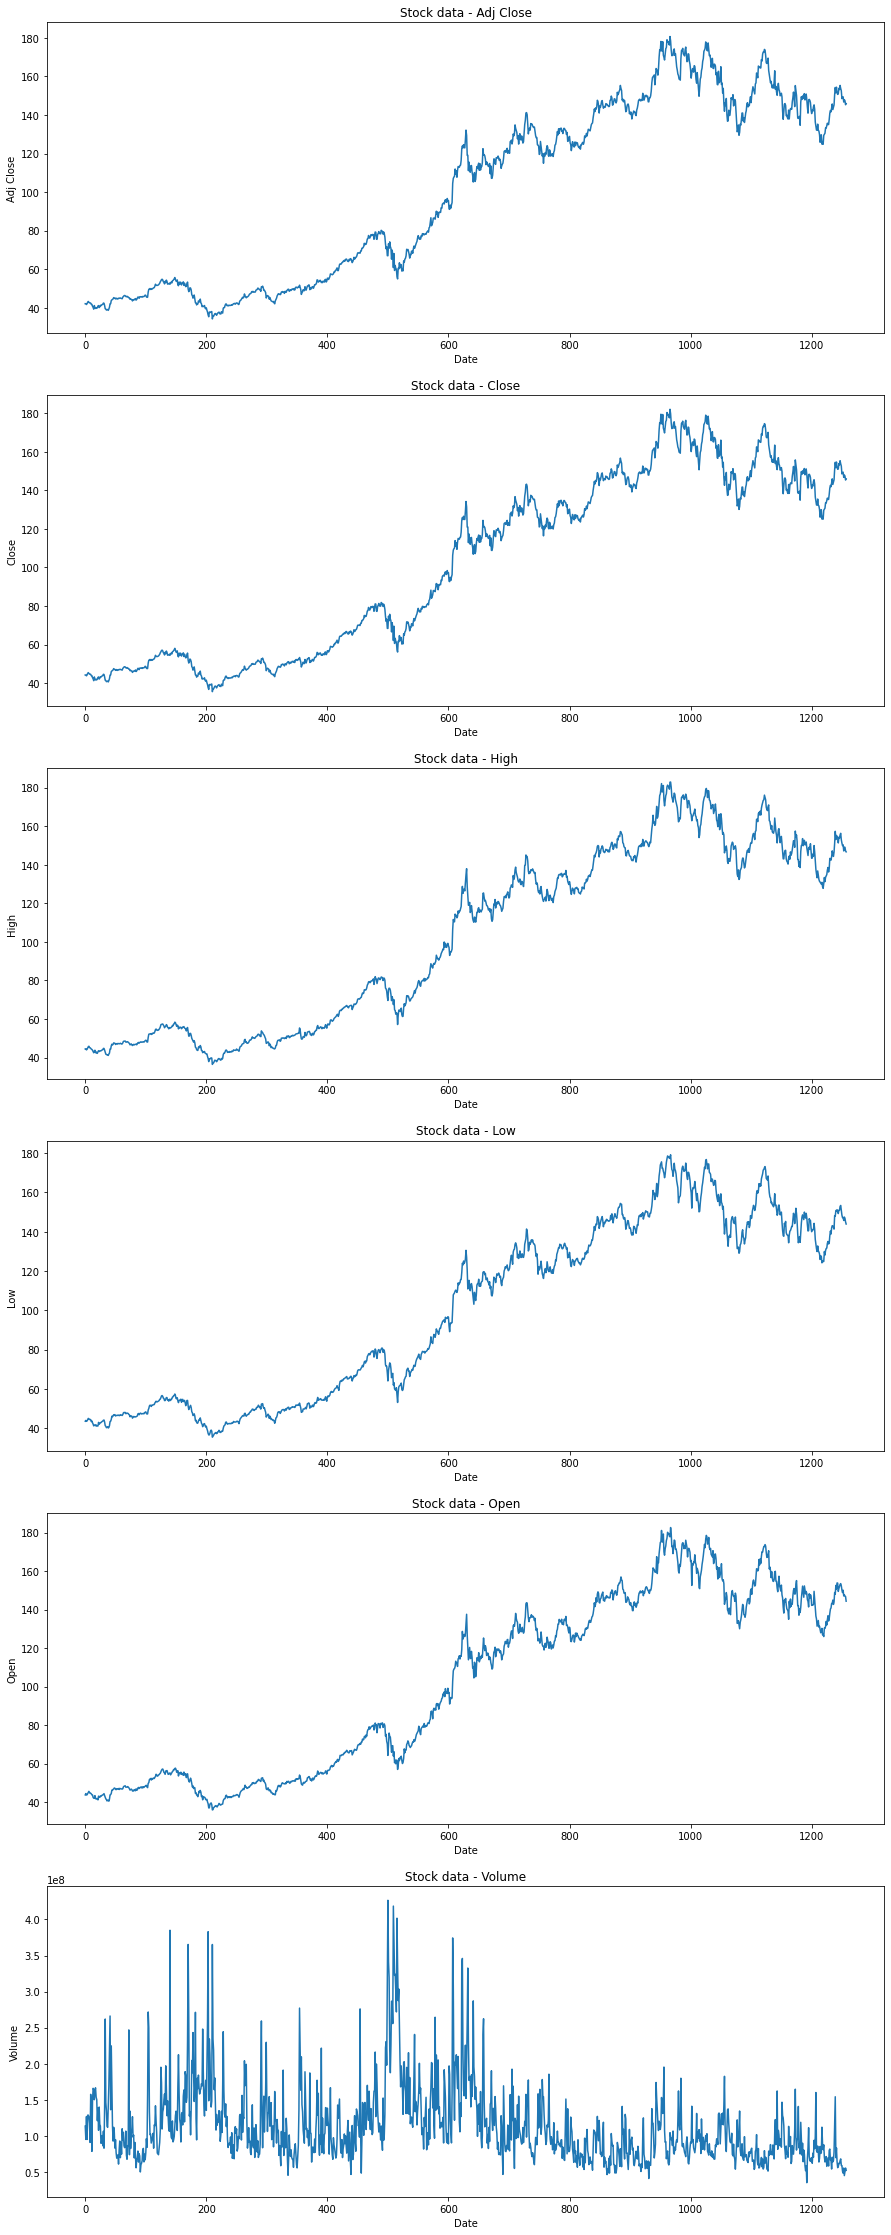

In [14]:
# Exploring data
if explore_data_flag:
    for symbol in data_symbols:
        print(f'Exploring {symbol} data:\n')
        explore_data_prices(
            data = data_original[symbol],
            show_info = True,
            show_example_data = True,
            plot_candlesticks = True,
            plot_signals = True)

## Preprocessing data

### Functions

In [15]:
def preprocess_data_types(data, show_info):
    ''' Treating data types. '''

    data['Volume'] = data['Volume'].astype('float64')

    if show_info:
        print('Treating data types.')
        explore_data_prices(
            data = data,
            show_info = True,
            show_example_data = False,
            plot_candlesticks = False,
            plot_signals = False)
        
    return data

In [16]:
def preprocess_timestamps_sorting(data, show_info):
    ''' Treating timestamps sorting. '''

    if show_info:
        print('Treating timestamps sorting.')
        print('Before:\n')
        explore_data_prices(
            data = data,
            show_info = False,
            show_example_data = True,
            plot_candlesticks = False,
            plot_signals = True)
    
    if data['Datetime'].is_monotonic:
        if show_info:
            print('The timestamps are monotonic.\n')
    else:
        print('The timestamps aren\'t monotonic!\n')
        data.sort_values(by=['Datetime'], inplace=True, ascending=True)

    if show_info:
        print('After:\n')
        explore_data_prices(
            data = data,
            show_info = False,
            show_example_data = True,
            plot_candlesticks = False,
            plot_signals = True)
        
    return data

In [17]:
def preprocess_missing_values(data, show_info):
    ''' Treating missing values. '''

    data_na_rows = data.isna().any(axis=1) # Rows with at least one missing value
    data_na_rows_num = sum(data_na_rows)
    
    if data_na_rows_num > 0:
        print('Error! Missing values found!\n')
        sys.exit()

    if show_info:
        print('Treating missing values.')
        print(f'There are {data_na_rows_num} rows with missing values.\n')

        if data_na_rows_num > 0:
            print('Presenting example rows with missing values:\n')
            print(data[data_na_rows].head())

        explore_data_prices(
            data = data,
            show_info = True,
            show_example_data = False,
            plot_candlesticks = False,
            plot_signals = False)
        
    return data

In [18]:
def preprocess_split_data(data, train_test_split, forecast_steps, show_info):
    ''' Splitting data to train and test sets. '''
    
    data_train_len = math.ceil(len(data) * train_test_split)

    data_train = data.iloc[0 : data_train_len]
    data_test = data.iloc[data_train_len-forecast_steps+1 :] # Not overlapping with the train FEATURES
    data_test = data_test.reset_index(drop=True) # Prevents issues when copying into data_test
    
    if show_info:
        print('data.shape =', data.shape)
        print('data_train.shape =', data_train.shape)
        print('data_test.shape =', data_test.shape)
        print()
        print('len(data) - (len(data_train) + len(data_test)) =', len(data) - (len(data_train) + len(data_test)))

    return data_train, data_test

In [19]:
def scale_df_cols_together(data_train, data_test, cols_to_scale, feature_range, show_info):
    ''' Scaling all training data columns together to a given range,
    then using the obtained scaling parameters to scale the testing data.
    The scaler will get a 2D array with 1 column, with shape (rows_num X 1),
    which will contain the concatenation of all the columns for scaling. '''

    # Defining objects
    num_cols = len(cols_to_scale)
    scaler = MinMaxScaler(feature_range=feature_range)

    # Scaling training data
    data_train_partial_scaled = scaler.fit_transform(
        data_train[cols_to_scale].to_numpy().reshape(-1,1))    
    data_train_partial_scaled = pd.DataFrame(data_train_partial_scaled.reshape(-1,num_cols),
                                             columns=cols_to_scale)
    data_train[cols_to_scale] = data_train_partial_scaled
    
    if show_info:
        print('cols_to_scale =', cols_to_scale, '\n')
        print('data_train_partial_scaled\n', data_train_partial_scaled.head(), '\n')
        print('data_train\n', data_train.head(), '\n')
    
    # Scaling the test data with the scaling parameters of the training data
    data_test_partial_scaled = scaler.transform(
        data_test[cols_to_scale].to_numpy().reshape(-1,1))
    data_test_partial_scaled = pd.DataFrame(data_test_partial_scaled.reshape(-1,num_cols),
                                            columns=cols_to_scale)
    data_test[cols_to_scale] = data_test_partial_scaled
    
    if show_info:
        print('data_test_partial_scaled\n', data_test_partial_scaled.head(), '\n')
        print('data_test\n', data_test.head(), '\n')
        print('#######################################################\n')

    return data_train, data_test, scaler

In [20]:
def preprocess_scale_data(data_train, data_test, show_info):
    ''' Scaling train and test data. '''

    # Defining variables
    data_train_scaled = data_train.copy(deep=True)
    data_test_scaled = data_test.copy(deep=True)
    cols_to_scale = {
        # 'prices': ['Adj Close','Close','High','Low','Open'],
        'Adj Close': ['Adj Close'],
        'Close': ['Close'],
        'High': ['High'],
        'Low': ['Low'],
        'Open': ['Open'],
        'Volume': ['Volume']
    }
    feature_range = (0,1)
    scalers = {k: None for k in cols_to_scale.keys()}
    
    # Scaling
    for cols_key in cols_to_scale.keys():
        data_train_scaled, data_test_scaled, scaler = \
            scale_df_cols_together(data_train_scaled, data_test_scaled,
                                   cols_to_scale[cols_key], feature_range, show_info=False)
        scalers[cols_key] = scaler
        
    if show_info:
        for data_to_explore in [data_train_scaled, data_test_scaled]:
            explore_data_prices(
                data = data_to_explore,
                show_info = True,
                show_example_data = True,
                plot_candlesticks = True,
                plot_signals = True)
        
    return data_train_scaled, data_test_scaled, scalers

In [21]:
def preprocess_data_prices(data, train_test_split, forecast_steps, show_info):
    ''' Preprocessing prices data. '''
    
    # Treating data types
    data = preprocess_data_types(data, show_info)

    # Verifying the timestamps are monotonic
    data = preprocess_timestamps_sorting(data, show_info)

    # Treating missing values
    data = preprocess_missing_values(data, show_info)
    
    # Splitting data
    data_train, data_test = \
        preprocess_split_data(data, train_test_split, forecast_steps, show_info)
        
    # Scaling data
    data_train_scaled, data_test_scaled, scalers = \
        preprocess_scale_data(data_train, data_test, show_info)
    
    return data, data_train_scaled, data_test_scaled, scalers

In [22]:
def preprocess_data_prices_symbols(data, train_test_split, forecast_steps, show_info):
    ''' Preprocessing prices data for multiple symbols. '''

    symbol_names = list(data.keys())
    data_preprocessed = {k:{} for k in symbol_names}
    scalers = {k:{} for k in symbol_names}

    for symbol in symbol_names:
        if show_info:
            print(f'Preprocessing prices data for {symbol}.\n')
            
        data_preprocessed_one_symbol, data_train_scaled, data_test_scaled, scalers_one_symbol = \
            preprocess_data_prices(data[symbol], train_test_split, forecast_steps, show_info)

        data_preprocessed[symbol]['data_preprocessed_one_symbol'] = data_preprocessed_one_symbol
        data_preprocessed[symbol]['data_train_scaled'] = data_train_scaled
        data_preprocessed[symbol]['data_test_scaled'] = data_test_scaled
        scalers[symbol] = scalers_one_symbol

        if show_info:
            print('#'*60, '\n')

    return data_preprocessed, scalers

### Calculation

In [23]:
# Preprocessing data
data_preprocessed, scalers = preprocess_data_prices_symbols(
    data_original, data_train_test_split, data_forecast_steps, show_info=False)

In [24]:
# Exploring preprocessed data
if explore_data_flag:
    len_train = len(data_preprocessed[data_symbol_eg]['data_train_scaled'])
    len_test = len(data_preprocessed[data_symbol_eg]['data_test_scaled'])
    
    print('len(data_original[data_symbol_eg]) =', len(data_original[data_symbol_eg]))
    print('len(data_preprocessed[data_symbol_eg]["data_train_scaled"]) =',
          len(data_preprocessed[data_symbol_eg]["data_train_scaled"]))
    print('len(data_preprocessed[data_symbol_eg]["data_test_scaled"]) =',
          len(data_preprocessed[data_symbol_eg]["data_test_scaled"]))
    print()
    print('len_train =', len_train)
    print('len_test =', len_test)
    print()
    print('data_lookback_steps =', data_lookback_steps)
    print('data_forecast_steps =', data_forecast_steps)
    print()
    print('len_train + len_test =', len_train + len_test)
    print('len_train + len_test - data_lookback_steps =', len_train + len_test - data_lookback_steps)
    print()
    print('len_train/(len_train + len_test) =', round(len_train/(len_train + len_test), 4))
    # print('len_train/(len_train + len_test + data_lookback_steps) =',
    #       round(len_train/(len_train + len_test + data_lookback_steps), 4))

len(data_original[data_symbol_eg]) = 1258
len(data_preprocessed[data_symbol_eg]["data_train_scaled"]) = 1007
len(data_preprocessed[data_symbol_eg]["data_test_scaled"]) = 251

len_train = 1007
len_test = 251

data_lookback_steps = 60
data_forecast_steps = 1

len_train + len_test = 1258
len_train + len_test - data_lookback_steps = 1198

len_train/(len_train + len_test) = 0.8005


## Features & targets - Prices

### Functions

In [25]:
def get_time_series_feats_and_targets(data, lookback_steps, forecast_steps):
    ''' Extracting time series features and targets from the data for one feature type.
    The features will contain samples of time series, beginning at increasingly shifted times.
    The targets will contain series following the corresponding training time series. '''

    # Calculating features and targets
    values = data.values
    x = []
    y = []
    
    for i in range(lookback_steps, len(data)-forecast_steps+1): # +1 since end is exclusive
        x.append(values[i-lookback_steps : i])
        y.append(values[i : i+forecast_steps])
        
    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    y = np.reshape(y, (y.shape[0], y.shape[1], 1))
    
    return x, y

In [26]:
def get_time_series_feats_and_targets_symbols(
    data, symbols, features_names, lookback_steps, forecast_steps):
    ''' Calculating features and targets.
    The input variables hierarchy: symbol - train/test - feature type (in dataframe column).
    The output variables hierarchy: symbol - feature type - train/test - features/targets. '''

    data_feats_and_targets = {}

    for symbol in symbols:
        data_feats_and_targets[symbol] = {}
        for feature_type in features_names:
            data_feats_and_targets[symbol][feature_type] = {}
            for data_type in ['train', 'test']:
                data_feats_and_targets[symbol][feature_type][data_type] = {}
                
                data_feats_and_targets[symbol][feature_type][data_type]['features'], \
                data_feats_and_targets[symbol][feature_type][data_type]['targets'] = \
                    get_time_series_feats_and_targets(
                        data = data[symbol][f'data_{data_type}_scaled'][feature_type],
                        lookback_steps = data_lookback_steps, 
                        forecast_steps = data_forecast_steps)
                    
    return data_feats_and_targets

### Calculation

In [27]:
# Calculating features and targets
data_feats_and_targets = get_time_series_feats_and_targets_symbols(
    data = data_preprocessed,
    symbols = data_symbols,
    features_names = data_features_names,
    lookback_steps = data_lookback_steps, 
    forecast_steps = data_forecast_steps)

## Preprocessing features & targets

### Functions

In [28]:
def fft_denoiser(signal, psd_th_percent, return_reals, show_info):
    ''' Denoises a signal using the fast fourier transform,
    by keeping the coefficients with a power spectrum density above a threshold. '''
    # Example noisy signal: np.sin(np.linspace(0,2*np.pi,100)) + np.random.uniform(-0.1,0.1,100)
    
    # Calculating the fast fourier transform
    signal_len = len(signal)
    fft = np.fft.fft(signal, signal_len)
    
    # Calculating power spectrum density = squared magnitude of each fft coefficient
    psd = fft * np.conj(fft) / signal_len

    # Filtering frequencies by PSD
    _mask = psd > psd.max() * psd_th_percent
    fft = _mask * fft
    
    # Calculating the inverse transform
    signal_denoised = np.fft.ifft(fft)
    
    # Returning the real values
    if return_reals:
        signal_denoised = signal_denoised.real
    
    # Plotting results
    if show_info:
        figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        axes[0].plot(signal)
        axes[0].set_title('Signal - before')
        axes[1].plot(signal_denoised)
        axes[1].set_title('Signal - after')
        plt.show()
        print()
        
        figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        axes[0].plot(fft.real)
        axes[0].set_title('FFT - Re')
        axes[1].plot(fft.imag)
        axes[1].set_title('FFT - Im')
        plt.show()
        print()

        plt.figure(figsize=(15,5))
        plt.plot(psd)
        plt.title('Power spectrum density')
        plt.show()
        print()
        print('Power spectrum density information:\n', pd.DataFrame(psd).describe(), '\n')

    return signal_denoised

In [29]:
def denoise_signal(signal, denoise_rolling_flag, denoise_rolling_steps,
    denoise_fft_flag, denoise_fft_psd_th_percent, show_info):
    ''' Remove noise from a single time series. '''
    
    if show_info:
        figure = plt.figure(figsize=(12, 6))
        plt.plot(signal)
        plt.title('Signal vs. Time steps - Before denoising')
        plt.xlabel('Time steps')
        plt.ylabel('Signal')
        plt.show()
    
    if denoise_rolling_flag:
        signal = pd.DataFrame(signal).rolling(denoise_rolling_steps).mean().dropna(axis=0).values

    if denoise_fft_flag:
        signal = fft_denoiser(
            signal = signal,
            psd_th_percent = denoise_fft_psd_th_percent,
            return_reals = True,
            show_info = show_info)

    if show_info:
        figure = plt.figure(figsize=(12, 6))
        plt.plot(signal)
        plt.title('Signal vs. Time steps - After denoising')
        plt.xlabel('Time steps')
        plt.ylabel('Signal')
        plt.show()
        print()
    
    return signal

In [30]:
def preprocess_remove_noise_features(data, denoise_rolling_flag, denoise_rolling_steps,
    denoise_fft_flag, denoise_fft_psd_th_percent, show_info):
    ''' Removing noise from features ONLY. '''

    data_denoised = copy.deepcopy(data)
    for symbol in data_symbols:
        for feature_type in ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']:
            for data_type in ['train','test']:
                x_samples = data[symbol][feature_type][data_type]['features']
                features_denoised = [] # Collecting denoised signals since they may get shortened

                for i_sample in range(0,len(x_samples)):
                    signal_1d = x_samples[i_sample,:].reshape(-1)
                    signal_denoised_1d = denoise_signal(
                        signal = signal_1d,
                        denoise_rolling_flag = denoise_rolling_flag,
                        denoise_rolling_steps = denoise_rolling_steps,
                        denoise_fft_flag = denoise_fft_flag,
                        denoise_fft_psd_th_percent = denoise_fft_psd_th_percent,
                        show_info = show_info)
                    features_denoised.append(signal_denoised_1d.reshape(-1,1))
                    
                data_denoised[symbol][feature_type][data_type]['features'] = np.array(features_denoised)

    return data_denoised

In [31]:
def denoise_signal_in_df(data, denoise_rolling_flag, denoise_rolling_steps, show_info):
    ''' Remove noise from a single time series. '''
    
    if show_info:
        figure = plt.figure(figsize=(12, 6))
        plt.plot(data)
        plt.title('Signal vs. Time steps - Before denoising')
        plt.xlabel('Time steps')
        plt.ylabel('Signal')
        plt.show()
    
    if denoise_rolling_flag:
        data = data.rolling(denoise_rolling_steps).mean()

    if show_info:
        figure = plt.figure(figsize=(12, 6))
        plt.plot(data)
        plt.title('Signal vs. Time steps - After denoising')
        plt.xlabel('Time steps')
        plt.ylabel('Signal')
        plt.show()
        print()

    return data

In [32]:
def preprocess_remove_noise_in_df(data, show_info):
    ''' Removing noise from prices data. '''

    data_denoised = data[['Datetime']]
    columns_to_denoise = ['Adj Close','Close','High','Low','Open','Volume']

    for column in columns_to_denoise:
        if show_info:
            print(f'Denoising "{column}".\n')
        data_denoised_one_column = denoise_signal_in_df(
            data = data[column],
            denoise_rolling_flag = False,
            denoise_rolling_steps = 5,
            denoise_fft_flag = True,

            show_info = show_info)
        data_denoised[column] = data_denoised_one_column
    
    # Removing missing values caused by denoising, e.g. by rolling mean
    data_denoised = data_denoised.dropna(axis='index').reset_index(drop=True)

    return data_denoised

### Calculation

In [33]:
# Preprocessing features and targets

# Removing noise
data_feats_and_targets_preprocessed = preprocess_remove_noise_features(
    data = data_feats_and_targets,
    denoise_rolling_flag = data_denoise_rolling_flag,
    denoise_rolling_steps = data_denoise_rolling_steps,
    denoise_fft_flag = data_denoise_fft_flag,
    denoise_fft_psd_th_percent = data_denoise_fft_psd_th_percent,
    show_info = False
    )

In [34]:
# Exploring data
if explore_data_flag:
    print(data_feats_and_targets_preprocessed.keys())
    print(data_feats_and_targets_preprocessed[data_symbol_eg].keys())
    print(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close'].keys())
    print(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']['train'].keys())
    print()
    for i in ['train','test']:
        for j in ['features','targets']:
            print(f'{i} {j}:')
            print(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close'][i][j].shape)
            print(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close'][i][j][:5,0])
            print()

dict_keys(['AAPL'])
dict_keys(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'])
dict_keys(['train', 'test'])
dict_keys(['features', 'targets'])

train features:
(947, 60, 1)
[[0.0540699 ]
 [0.05406163]
 [0.05131677]
 [0.05435974]
 [0.05898793]]

train targets:
(947, 1, 1)
[[0.07240453]
 [0.07137522]
 [0.0768815 ]
 [0.07947951]
 [0.08189767]]

test features:
(191, 60, 1)
[[0.8667199 ]
 [0.86714149]
 [0.82477956]
 [0.8180843 ]
 [0.85973635]]

test targets:
(191, 1, 1)
[[0.78332931]
 [0.77789071]
 [0.77700692]
 [0.79400259]
 [0.75436893]]



# Models

## Functions - Training

In [36]:
def train_model(
    model, outputs_names, train_x, train_y,
    train_model_flag, save_model_flag, load_model_flag, model_path,
    training_epochs, training_batch_size, training_validation_split,
    training_verbose, training_callbacks,
    show_model_summary, 
    plot_training_loss, plot_training_metric, plot_training_metric_names, plot_log_scale):
    ''' Training a neural network model and presenting the training results. '''

    # Initializing variables
    train_history = None

    # Training the model
    if train_model_flag:
        train_history = model.fit(
            x = train_x,
            y = train_y,
            epochs = training_epochs,
            batch_size = training_batch_size,
            validation_split = training_validation_split,
            shuffle = True, # True by default
            verbose = training_verbose,
            callbacks = training_callbacks # Includes early stopping
            )
        train_history_dict = train_history.history # Converting to a dictionary
        if training_verbose > 0:
            print()

    # Saving model
    if train_model_flag and save_model_flag:
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        save_model(model, model_path)
        print()
        print('Saved model to:')
        print(model_path, '\n')
        
    # Loading model
    if load_model_flag:
        model = load_model(model_path)
        print('Loaded model from:')
        print(model_path, '\n')

    # Presenting model summary
    if show_model_summary:
        print('Presenting model summary:\n')
        model.summary()
        print()

    # Plotting training history
    if train_model_flag:
        if len(outputs_names) < 2:
            if plot_training_loss or plot_training_metric:
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

            # Plotting training loss
            if plot_training_loss:
                print('Final loss - Training: {:.3e}, validation: {:.3e}'.format(
                    train_history_dict['loss'][-1], train_history_dict['val_loss'][-1]))

                axes[0].plot(train_history_dict['loss']) # Training loss
                axes[0].plot(train_history_dict['val_loss']) # Validation loss
                axes[0].set_title('Training loss vs. Epochs\n(Final loss: Training - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                                %(train_history_dict['loss'][-1], train_history_dict['val_loss'][-1],
                                len(train_y), training_batch_size, training_validation_split), fontsize=font_size)
                axes[0].set_ylabel('Loss', fontsize=font_size)
                axes[0].set_xlabel('Epoch', fontsize=font_size)
                axes[0].legend(['Training Data', 'Validation Data'], loc='upper right', fontsize=font_size)
                axes[0].tick_params(labelsize=tick_size)
                if plot_log_scale: # Choosing whether to plot with a logarithmic scale
                    axes[0].semilogy()

            # Plotting training metric
            if plot_training_metric:
                training_metric = list(plot_training_metric_names.values())[0]
                print(f'Final {training_metric}' + ' - Training: {:.2e}, validation: {:.2e}'.format(
                    train_history_dict[f'{training_metric}'][-1], train_history_dict[f'val_{training_metric}'][-1]))

                axes[1].plot(train_history_dict[f'{training_metric}']) # Training metric
                axes[1].plot(train_history_dict[f'val_{training_metric}']) # Validation metric
                axes[1].set_title(f'Training {training_metric} vs. Epochs\n(Final {training_metric}: Training - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                    %(train_history_dict[f'{training_metric}'][-1], train_history_dict[f'val_{training_metric}'][-1],
                    len(train_y), training_batch_size, training_validation_split), fontsize=font_size)
                axes[1].set_ylabel(f'{training_metric}', fontsize=font_size)
                axes[1].set_xlabel('Epoch', fontsize=font_size)
                axes[1].legend(['Training Data', 'Validation Data'], loc='lower right', fontsize=font_size)
                axes[1].tick_params(labelsize=tick_size)
                # if plot_log_scale: # Choosing whether to plot with a logarithmic scale
                #     axes[1].semilogy()

            if save_model_flag:
                plt.savefig(model_path + 'Training_metrics.png', facecolor='white', bbox_inches='tight')

            if plot_training_loss or plot_training_metric:
                print()
                plt.show()
                print()

        else:
            # Going over the different model outputs
            for output_name in outputs_names:
                if plot_training_loss or plot_training_metric:
                    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

                # Plotting training loss
                if plot_training_loss:
                    print(f'Final {output_name} loss' + ' - Training: {:.3e}, validation: {:.3e}'.format(
                        train_history_dict[f'{output_name}_loss'][-1],
                        train_history_dict[f'val_{output_name}_loss'][-1]))

                    axes[0].plot(train_history_dict[f'{output_name}_loss']) # Training loss
                    axes[0].plot(train_history_dict[f'val_{output_name}_loss']) # Validation loss
                    axes[0].set_title(f'Training {output_name} loss' + ' vs. Epochs\n(Final loss: Training - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                                    %(train_history_dict[f'{output_name}_loss'][-1],
                                    train_history_dict[f'val_{output_name}_loss'][-1],
                                    len(train_x), training_batch_size, training_validation_split), fontsize=font_size)
                    axes[0].set_ylabel('Loss', fontsize=font_size)
                    axes[0].set_xlabel('Epoch', fontsize=font_size)
                    axes[0].legend(['Training Data', 'Validation Data'], loc='best', fontsize=font_size)
                    axes[0].tick_params(labelsize=tick_size)
                    if plot_log_scale:
                        axes[0].semilogy()

                # Plotting training metric
                if plot_training_metric:
                    training_metric = plot_training_metric_names[output_name]
                    print(f'Final {output_name} {training_metric}' + ' - Training: {:.2%}, validation: {:.2%}'.format(
                        train_history_dict[f'{output_name}_{training_metric}'][-1],
                        train_history_dict[f'val_{output_name}_{training_metric}'][-1]))

                    axes[1].plot(train_history_dict[f'{output_name}_{training_metric}']) # Training metric
                    axes[1].plot(train_history_dict[f'val_{output_name}_{training_metric}']) # Validation metric
                    axes[1].set_title(f'Training {output_name} {training_metric} vs. Epochs\n(Final {training_metric}:\nTraining - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                                    %(train_history_dict[f'{output_name}_{training_metric}'][-1],
                                    train_history_dict[f'val_{output_name}_{training_metric}'][-1],
                                    len(train_x), training_batch_size, training_validation_split), fontsize=font_size)
                    axes[1].set_ylabel(f'{output_name} {training_metric}', fontsize=font_size)
                    axes[1].set_xlabel('Epoch', fontsize=font_size)
                    axes[1].legend(['Training Data', 'Validation Data'], loc='best', fontsize=font_size)
                    axes[1].tick_params(labelsize=tick_size)
                    # if plot_log_scale:
                    #     axes[1].semilogy()

                if save_model_flag:
                    plt.savefig(model_path + f'Training_metrics_{output_name}.png',
                                facecolor='white', bbox_inches='tight')

                if plot_training_loss or plot_training_metric:
                    print()
                    plt.show()
                    print()

    return model, train_history

In [37]:
def train_models_and_data(models_and_data):
    ''' Trains models. '''

    for model_name in models_and_data.keys():
        print(f'Training {model_name} model.\n')
        train_history = models_and_data[model_name]['model'].fit(
            x = models_and_data[model_name]['train_x'],
            y = models_and_data[model_name]['train_y'],
            batch_size = 1,
            validation_split = 0.2,
            shuffle = True,
            epochs = 3,
            verbose = 1,
            callbacks = EarlyStopping(monitor = 'val_loss', mode = 'min',
                                    restore_best_weights = True, patience = 5)
            )
        print('\n' + '#'*60 + '\n')

    return models_and_data

## Functions - Evaluating

In [38]:
def evaluate_model(model, model_name, test_x_unprocessed, test_x, test_y, scaler,
    data_original, train_test_split, lookback_steps, show_eval, plot_predictions):
    ''' Evaluates the performance of a model on test data,
    and returns the metrics and predictions. '''

    # Defining variables
    eval_metrics_cols = ['model_name','mae','mape','mse','rmse',
        'trend_start_bal_accuracy','trend_start_accuracy',
        'trend_end_bal_accuracy','trend_end_accuracy',
        'trend_consec_start_bal_accuracy','trend_consec_start_accuracy',
        'trend_consec_end_bal_accuracy','trend_consec_end_accuracy']
    eval_metrics = pd.DataFrame(data=np.zeros((1,len(eval_metrics_cols))),
                                columns=eval_metrics_cols)
    eval_metrics.loc[0,'model_name'] = model_name

    # Predicting
    pred_y = model.predict(test_x)
    pred_y = np.reshape(pred_y, (pred_y.shape[0], pred_y.shape[1], 1))
    print()

    # Unscaling data before evaluating
    test_x_unprocessed_unscaled = np.array(test_x_unprocessed)
    test_x_unscaled = np.array(test_x) # .reshape(191, 1, 60)
    test_y_unscaled = np.array(test_y)
    pred_y_unscaled = np.array(pred_y)
    for i in range(0,test_x_unscaled.shape[0]):
        test_x_unprocessed_unscaled[i] = scaler.inverse_transform(test_x_unprocessed_unscaled[i])
        test_x_unscaled[i] = scaler.inverse_transform(test_x_unscaled[i])
        test_y_unscaled[i] = scaler.inverse_transform(test_y_unscaled[i])
        pred_y_unscaled[i] = scaler.inverse_transform(pred_y_unscaled[i])
    
    # From this point it is assumed we only predict a single feature type ! ! !
    feat_type_index = 0

    # Calculating regression metrics
    test_y_unscaled_2d = test_y_unscaled[:,:,feat_type_index]
    pred_y_unscaled_2d = pred_y_unscaled[:,:,feat_type_index]
    eval_metrics.loc[0,'mae'] = metrics.mean_absolute_error(test_y_unscaled_2d, pred_y_unscaled_2d)
    eval_metrics.loc[0,'mape'] = metrics.mean_absolute_percentage_error(test_y_unscaled_2d, pred_y_unscaled_2d)
    eval_metrics.loc[0,'mse'] = metrics.mean_squared_error(test_y_unscaled_2d, pred_y_unscaled_2d)
    eval_metrics.loc[0,'rmse'] = np.sqrt(eval_metrics.loc[0,'mse'])

    # Calculating binary classification metrics

    # Evaluating if the model predicts correctly whether the start/end of each predicted series
    # is above or below the END of the FEATURES series. Hence the "0" or "-1".
    # Notice we use the test features BEFORE denoising them.
    test_y_is_above_test_x = \
        (test_y_unscaled[:,0,feat_type_index] - test_x_unprocessed_unscaled[:,-1,feat_type_index]) > 0
    pred_y_is_above_test_x = \
        (pred_y_unscaled[:,0,feat_type_index] - test_x_unprocessed_unscaled[:,-1,feat_type_index]) > 0
    eval_metrics.loc[0,'trend_start_bal_accuracy'] = metrics.balanced_accuracy_score(
        test_y_is_above_test_x, pred_y_is_above_test_x)
    eval_metrics.loc[0,'trend_start_accuracy'] = metrics.accuracy_score(
        test_y_is_above_test_x, pred_y_is_above_test_x)

    test_y_is_above_test_x = \
        (test_y_unscaled[:,-1,feat_type_index] - test_x_unprocessed_unscaled[:,-1,feat_type_index]) > 0
    pred_y_is_above_test_x = \
        (pred_y_unscaled[:,-1,feat_type_index] - test_x_unprocessed_unscaled[:,-1,feat_type_index]) > 0
    eval_metrics.loc[0,'trend_end_bal_accuracy'] = metrics.balanced_accuracy_score(
        test_y_is_above_test_x, pred_y_is_above_test_x)
    eval_metrics.loc[0,'trend_end_accuracy'] = metrics.accuracy_score(
        test_y_is_above_test_x, pred_y_is_above_test_x)

    # Evaluating if the model predicts correctly whether the start/end of each predicted series
    # is above or below the start/end of the NEXT PREDICTED SERIES. Hence the diff and "0" or "-1".
    test_y_is_diff_positive = np.diff(test_y_unscaled[:,0,feat_type_index], n=1) > 0
    pred_y_is_diff_positive = np.diff(pred_y_unscaled[:,0,feat_type_index], n=1) > 0
    eval_metrics.loc[0,'trend_consec_start_bal_accuracy'] = metrics.balanced_accuracy_score(
        test_y_is_diff_positive, pred_y_is_diff_positive)
    eval_metrics.loc[0,'trend_consec_start_accuracy'] = metrics.accuracy_score(
        test_y_is_diff_positive, pred_y_is_diff_positive)

    test_y_is_diff_positive = np.diff(test_y_unscaled[:,-1,feat_type_index], n=1) > 0
    pred_y_is_diff_positive = np.diff(pred_y_unscaled[:,-1,feat_type_index], n=1) > 0
    eval_metrics.loc[0,'trend_consec_end_bal_accuracy'] = metrics.balanced_accuracy_score(
        test_y_is_diff_positive, pred_y_is_diff_positive)
    eval_metrics.loc[0,'trend_consec_end_accuracy'] = metrics.accuracy_score(
        test_y_is_diff_positive, pred_y_is_diff_positive)
    
    eval_metrics = eval_metrics.round(4)
    if show_eval:
        print('Presenting evaluation metrics:\n')
        print(eval_metrics, '\n')  

    if plot_predictions:
        # Plotting predictions
        symbol_for_plot = data_symbol_eg
        datetimes = data_original[symbol_for_plot]['Datetime']
        data_train_len = math.ceil(len(data_original[symbol_for_plot]) * train_test_split)
        data_unsplit_for_plot = data_original[symbol_for_plot]['Adj Close']
        
        plt.figure(figsize=(20,10))
        plt.plot(datetimes[:data_train_len], data_unsplit_for_plot[:data_train_len]) # Train data before splitting
        plt.plot(datetimes[data_train_len:], data_unsplit_for_plot[data_train_len:]) # Test data before splitting
        plt.plot(datetimes[data_train_len + lookback_steps:], pred_y_unscaled.reshape(-1)) # Predictions for test_y
        plt.title(f'{symbol_for_plot} price predictions - {model_name} model', fontsize=font_size)
        plt.xlabel('Date', fontsize=font_size)
        plt.ylabel('Price [$]', fontsize=font_size)
        plt.legend(['Training', 'Testing', 'Predictions'], loc='lower right', fontsize=font_size)
        plt.tick_params(labelsize=tick_size)
        plt.show()
        
    return eval_metrics, pred_y_unscaled

In [39]:
def evaluate_model_old(model, test_x, test_y, show_eval):
    ''' Evaluates the performance of a model on test data,
    and returns the evaluation metrics names and values. '''
    
    eval_metrics_names = model.metrics_names
    eval_metrics = model.evaluate(x = test_x, y = test_y, verbose = 1)
    print()
    eval_metrics = [round(x, 4) for x in eval_metrics]

    if show_eval:
        print('Presenting evaluation metrics:\n')
        for i in range(0,len(eval_metrics_names)):
            print(f'{eval_metrics_names[i]}: {eval_metrics[i]}')

    return eval_metrics_names, eval_metrics

In [40]:
def evaluate_models(models_and_data, data_original,
    train_test_split, lookback_steps, plot_predictions, show_eval):
    ''' Evaluate models and return evaluation metrics. '''
    
    eval_metrics = []
    for model_name in models_and_data.keys():
        eval_metrics_one_model = evaluate_model(
            models_and_data[model_name], data_original,
            train_test_split, lookback_steps, plot_predictions, show_eval)

    eval_metrics = pd.concat([eval_metrics, eval_metrics_one_model])

    return eval_metrics

In [41]:
# # Evaluating models
# for model_name in models.keys():
#     eval_metrics = evaluate_model(
#         model_and_data = models_and_data[model_name],
#         model_name = model_name,
#         data_original = data_original,
#         train_test_split = data_train_test_split,
#         lookback_steps = data_lookback_steps,
#         plot_predictions = True,
#         show_eval = True)

## Variables

In [42]:
# Defining variables
eval_metrics_cols = ['model_name','mae','mape','mse','rmse',
        'trend_start_bal_accuracy','trend_start_accuracy',
        'trend_end_bal_accuracy','trend_end_accuracy',
        'trend_consec_start_bal_accuracy','trend_consec_start_accuracy',
        'trend_consec_end_bal_accuracy','trend_consec_end_accuracy']
eval_metrics_all = pd.DataFrame(columns=eval_metrics_cols)

## LSTM

### Settings

In [43]:
# General settings
run_model = ml_run_lstm_single

In [44]:
# Training settings
model_name = 'lstm_single'
train_model_flag = ml_train_flag
save_model_flag = ml_save_flag
load_model_flag = ml_load_flag
model_path = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 20
training_batch_size = 128
training_validation_split = 0.2
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 5)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

# Metrics:
# 'mean_squared_error'
# tf.keras.metrics.RootMeanSquaredError(name='rmse')
# 'mean_absolute_percentage_error' # Gives very high value
# tf.keras.losses.MeanAbsolutePercentageError(name='mape') # Causes error

In [45]:
# Data settings
data_for_model = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
train_x = data_for_model['train']['features']
train_y = data_for_model['train']['targets']
test_x = data_for_model['test']['features']
test_y = data_for_model['test']['targets']
scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

if explore_data_flag:
    print('train_x.shape =', train_x.shape)
    print('train_y.shape =', train_y.shape)
    print('test_x.shape =', test_x.shape)
    print('test_y.shape =', test_y.shape)
    print()
    print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

train_x.shape = (947, 60, 1)
train_y.shape = (947, 1, 1)
test_x.shape = (191, 60, 1)
test_y.shape = (191, 1, 1)

test_x_unprocessed.shape = (191, 60, 1)


In [46]:
# Model settings
model = keras.Sequential([
    InputLayer(input_shape=(train_x.shape[1], train_y.shape[1])), # [(batch_size,) timesteps, features_dim]
    LSTM(100, return_sequences=False),
    Dense(25, activation=None),
    Dense(1, activation=None, name='output')
])

model.compile(
    optimizer = Adam(learning_rate=0.0003),
    loss='mean_squared_error',
    metrics = training_metrics,
    )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 43,351
Trainable params: 43,351
Non-trainable params: 0
_________________________________________________________________


### Training

Epoch 1/20
6/6 [==============================] - 10s 735ms/step - loss: 0.0604 - rmse: 0.2458 - val_loss: 0.1728 - val_rmse: 0.4157
Epoch 2/20
6/6 [==============================] - 1s 232ms/step - loss: 0.0144 - rmse: 0.1200 - val_loss: 0.0199 - val_rmse: 0.1411
Epoch 3/20
6/6 [==============================] - 1s 207ms/step - loss: 0.0046 - rmse: 0.0675 - val_loss: 0.0043 - val_rmse: 0.0653
Epoch 4/20
6/6 [==============================] - 1s 185ms/step - loss: 0.0067 - rmse: 0.0816 - val_loss: 0.0011 - val_rmse: 0.0333
Epoch 5/20
6/6 [==============================] - 1s 197ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0075 - val_rmse: 0.0867
Epoch 6/20
6/6 [==============================] - 1s 217ms/step - loss: 0.0020 - rmse: 0.0447 - val_loss: 0.0133 - val_rmse: 0.1155
Epoch 7/20
6/6 [==============================] - 1s 198ms/step - loss: 0.0019 - rmse: 0.0438 - val_loss: 0.0074 - val_rmse: 0.0860
Epoch 8/20
6/6 [==============================] - 1s 247ms/step - loss: 0.0


Saved model to:
Models/model_lstm_single_AAPL_1d/ 

Loaded model from:
Models/model_lstm_single_AAPL_1d/ 

Presenting model summary:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 43,351
Trainable params: 43,351
Non-trainable params: 0
_________________________________________________________________

Final loss - Training: 4.925e-04, validation: 9.897e-04
Final rmse - Training: 2.22e-02, validation: 3.15e-02



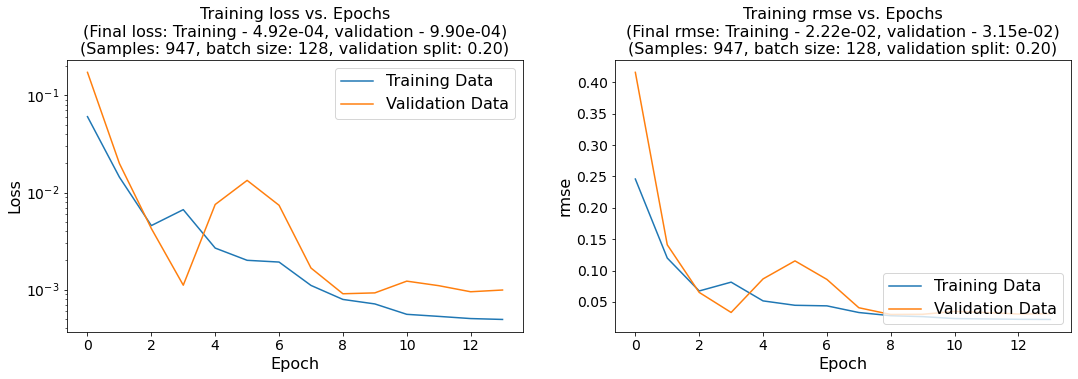

In [47]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        train_model_flag = train_model_flag,
        save_model_flag = save_model_flag,
        load_model_flag = load_model_flag,
        model_path = model_path,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating

6/6 [==============================] - 1s 16ms/step

Presenting evaluation metrics:

    model_name     mae    mape      mse    rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0  lstm_single  5.0271  0.0347  36.2635  6.0219                    0.5075                0.5079                  0.5075              0.5079                              0.5                          0.5                            0.5                        0.5 



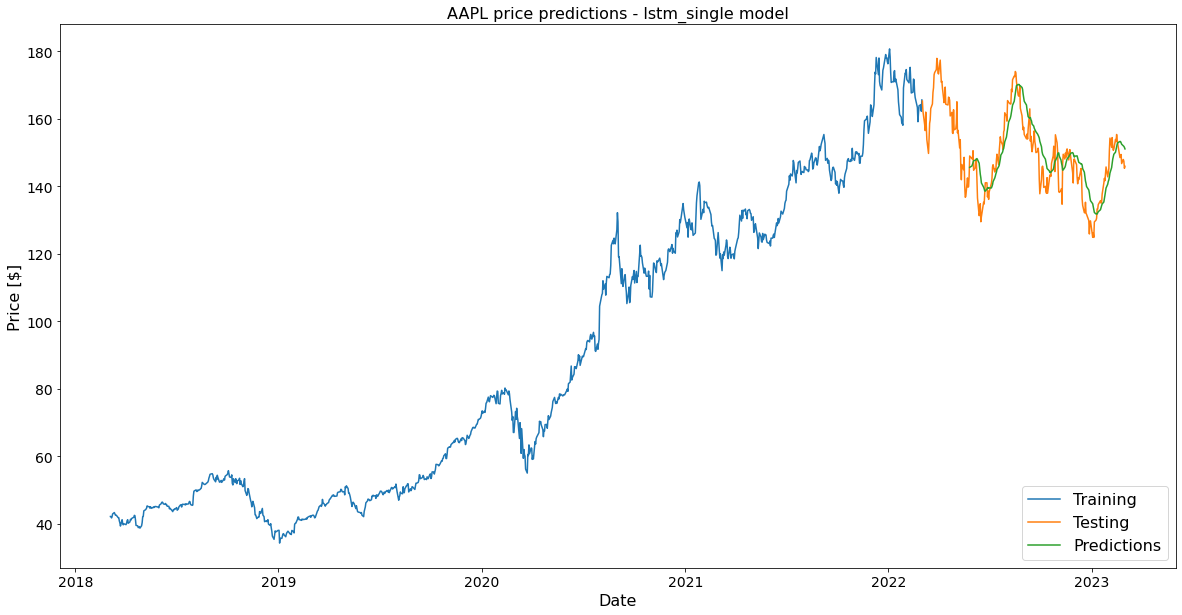

In [48]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## Deep LSTM

### Settings

In [49]:
# General settings
run_model = ml_run_lstm_deep

In [50]:
# Training settings
model_name = 'lstm_deep'
train_model_flag = ml_train_flag
save_model_flag = ml_save_flag
load_model_flag = ml_load_flag
model_path = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 20
training_batch_size = 128
training_validation_split = 0.2
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 5)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [51]:
# Data settings
data_for_model = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
train_x = data_for_model['train']['features']
train_y = data_for_model['train']['targets']
test_x = data_for_model['test']['features']
test_y = data_for_model['test']['targets']
scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

if explore_data_flag:
    print('train_x.shape =', train_x.shape)
    print('train_y.shape =', train_y.shape)
    print('test_x.shape =', test_x.shape)
    print('test_y.shape =', test_y.shape)
    print()
    print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

train_x.shape = (947, 60, 1)
train_y.shape = (947, 1, 1)
test_x.shape = (191, 60, 1)
test_y.shape = (191, 1, 1)

test_x_unprocessed.shape = (191, 60, 1)


In [52]:
# Model settings
model = keras.Sequential([
    InputLayer(input_shape=(train_x.shape[1], train_y.shape[1])), # [(batch_size,) timesteps, features_dim]
    LSTM(100, return_sequences=True),
    LSTM(100, return_sequences=False),
    Dense(25, activation=None),
    Dense(1, activation=None, name='output')
    ])

model.compile(
    optimizer = Adam(learning_rate=0.0003),
    loss='mean_squared_error',
    metrics = training_metrics,
    )

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


### Training

Epoch 1/20
6/6 [==============================] - 9s 492ms/step - loss: 0.0694 - rmse: 0.2634 - val_loss: 0.1006 - val_rmse: 0.3172
Epoch 2/20
6/6 [==============================] - 1s 247ms/step - loss: 0.0087 - rmse: 0.0931 - val_loss: 0.0210 - val_rmse: 0.1450
Epoch 3/20
6/6 [==============================] - 2s 258ms/step - loss: 0.0097 - rmse: 0.0984 - val_loss: 0.0041 - val_rmse: 0.0639
Epoch 4/20
6/6 [==============================] - 1s 253ms/step - loss: 0.0036 - rmse: 0.0601 - val_loss: 0.0296 - val_rmse: 0.1721
Epoch 5/20
6/6 [==============================] - 1s 248ms/step - loss: 0.0040 - rmse: 0.0633 - val_loss: 0.0107 - val_rmse: 0.1035
Epoch 6/20
6/6 [==============================] - 2s 340ms/step - loss: 0.0016 - rmse: 0.0402 - val_loss: 0.0019 - val_rmse: 0.0433
Epoch 7/20
6/6 [==============================] - 2s 415ms/step - loss: 0.0016 - rmse: 0.0404 - val_loss: 0.0017 - val_rmse: 0.0417
Epoch 8/20
6/6 [==============================] - 2s 348ms/step - loss: 9.51


Saved model to:
Models/model_lstm_deep_AAPL_1d/ 

Loaded model from:
Models/model_lstm_deep_AAPL_1d/ 

Presenting model summary:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________

Final loss - Training: 7.708e-04, validation: 1.

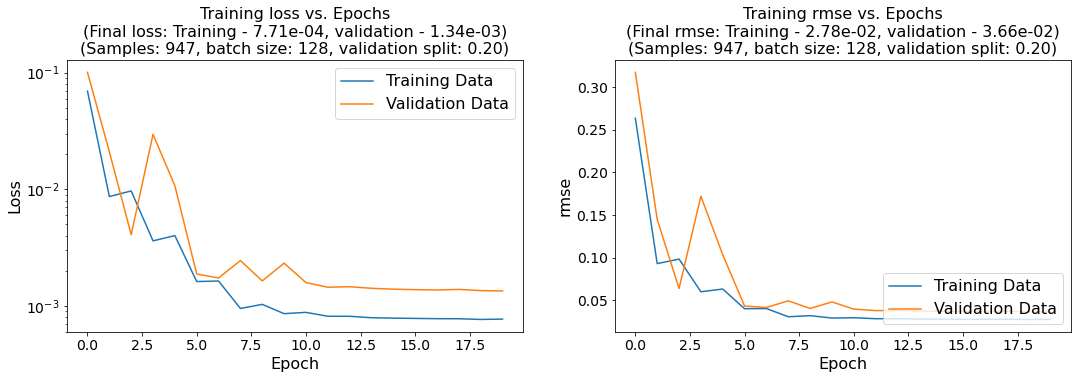

In [53]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        train_model_flag = train_model_flag,
        save_model_flag = save_model_flag,
        load_model_flag = load_model_flag,
        model_path = model_path,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating

6/6 [==============================] - 1s 36ms/step

Presenting evaluation metrics:

  model_name     mae   mape      mse    rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0  lstm_deep  6.2547  0.043  53.6975  7.3279                    0.5024                0.5026                  0.5024              0.5026                           0.5158                       0.5158                         0.5158                     0.5158 



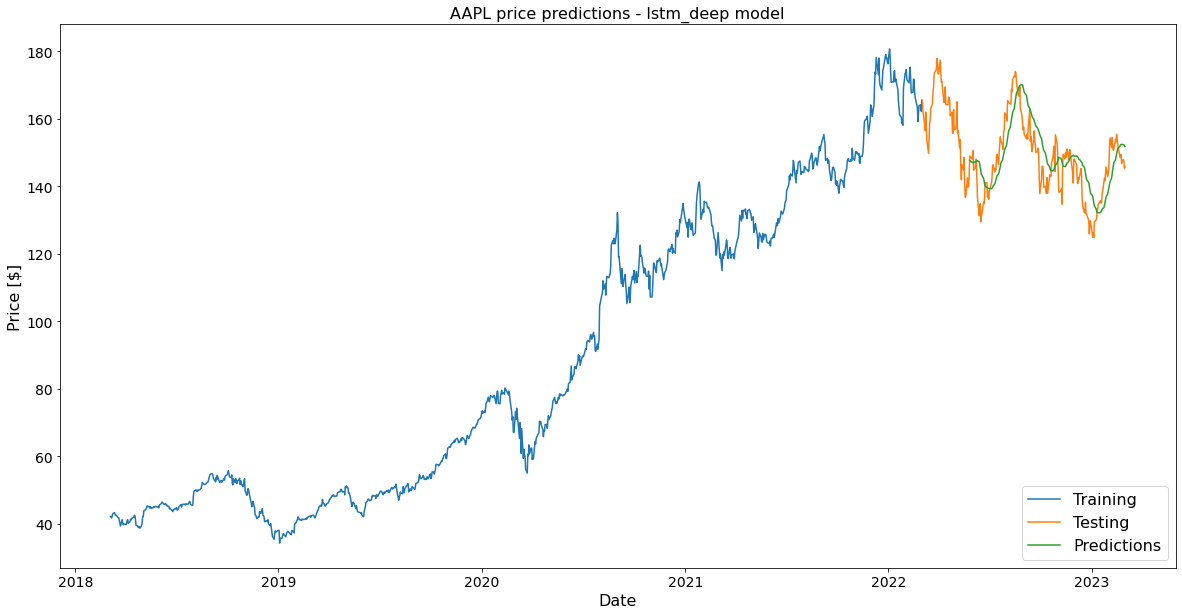

In [54]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## Bidirectional LSTM

### Settings

In [55]:
# General settings
run_model = ml_run_lstm_bidir

In [56]:
# Training settings
model_name = 'lstm_bidir'
train_model_flag = ml_train_flag
save_model_flag = ml_save_flag
load_model_flag = ml_load_flag
model_path = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 20
training_batch_size = 128
training_validation_split = 0.2
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 5)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [57]:
# Data settings
data_for_model = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
train_x = data_for_model['train']['features']
train_y = data_for_model['train']['targets']
test_x = data_for_model['test']['features']
test_y = data_for_model['test']['targets']
scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

if explore_data_flag:
    print('train_x.shape =', train_x.shape)
    print('train_y.shape =', train_y.shape)
    print('test_x.shape =', test_x.shape)
    print('test_y.shape =', test_y.shape)
    print()
    print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

train_x.shape = (947, 60, 1)
train_y.shape = (947, 1, 1)
test_x.shape = (191, 60, 1)
test_y.shape = (191, 1, 1)

test_x_unprocessed.shape = (191, 60, 1)


In [58]:
# Model settings
model = keras.Sequential([
    InputLayer(input_shape=(train_x.shape[1], train_y.shape[1])), # [(batch_size,) timesteps, features_dim]
    Bidirectional(LSTM(100, return_sequences=False)),
    Dense(25, activation=None),
    Dense(1, activation=None, name='output')
])

model.compile(
    optimizer = Adam(learning_rate=0.0003),
    loss='mean_squared_error',
    metrics = training_metrics,
    )

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              81600     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 25)                5025      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 86,651
Trainable params: 86,651
Non-trainable params: 0
_________________________________________________________________


### Training

Epoch 1/20
6/6 [==============================] - 9s 574ms/step - loss: 0.0992 - rmse: 0.3150 - val_loss: 0.2221 - val_rmse: 0.4713
Epoch 2/20
6/6 [==============================] - 1s 172ms/step - loss: 0.0164 - rmse: 0.1281 - val_loss: 0.0043 - val_rmse: 0.0656
Epoch 3/20
6/6 [==============================] - 1s 166ms/step - loss: 0.0113 - rmse: 0.1064 - val_loss: 0.0179 - val_rmse: 0.1337
Epoch 4/20
6/6 [==============================] - 1s 180ms/step - loss: 0.0099 - rmse: 0.0997 - val_loss: 0.0021 - val_rmse: 0.0463
Epoch 5/20
6/6 [==============================] - 1s 182ms/step - loss: 0.0038 - rmse: 0.0619 - val_loss: 0.0157 - val_rmse: 0.1254
Epoch 6/20
6/6 [==============================] - 1s 181ms/step - loss: 0.0043 - rmse: 0.0653 - val_loss: 0.0187 - val_rmse: 0.1366
Epoch 7/20
6/6 [==============================] - 1s 171ms/step - loss: 0.0036 - rmse: 0.0600 - val_loss: 0.0070 - val_rmse: 0.0837
Epoch 8/20
6/6 [==============================] - 1s 175ms/step - loss: 0.00


Saved model to:
Models/model_lstm_bidir_AAPL_1d/ 

Loaded model from:
Models/model_lstm_bidir_AAPL_1d/ 

Presenting model summary:

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              81600     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 25)                5025      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 86,651
Trainable params: 86,651
Non-trainable params: 0
_________________________________________________________________

Final loss - Training: 1.267e-03, validation: 1.380e-03
Final rmse - Training: 3.56e-02, validation: 3.72e-02



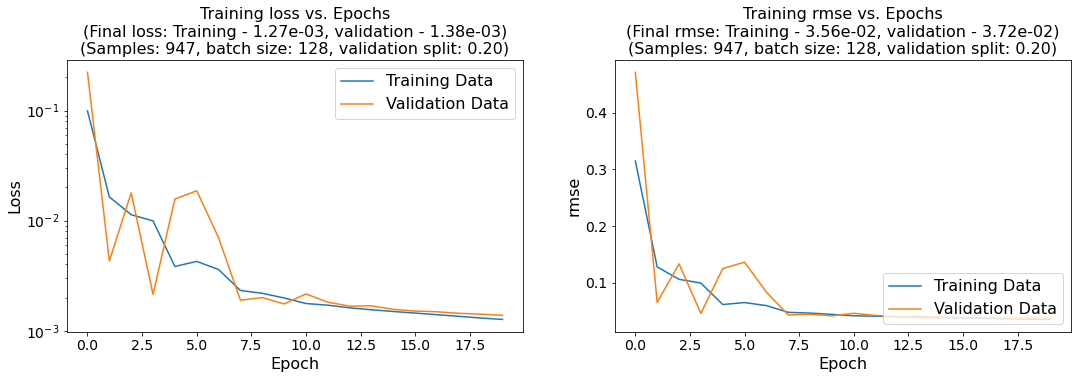

In [59]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        train_model_flag = train_model_flag,
        save_model_flag = save_model_flag,
        load_model_flag = load_model_flag,
        model_path = model_path,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating

6/6 [==============================] - 2s 22ms/step

Presenting evaluation metrics:

   model_name     mae    mape       mse     rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0  lstm_bidir  8.6363  0.0609  109.3996  10.4594                    0.5425                0.5445                  0.5425              0.5445                           0.4947                       0.4947                         0.4947                     0.4947 



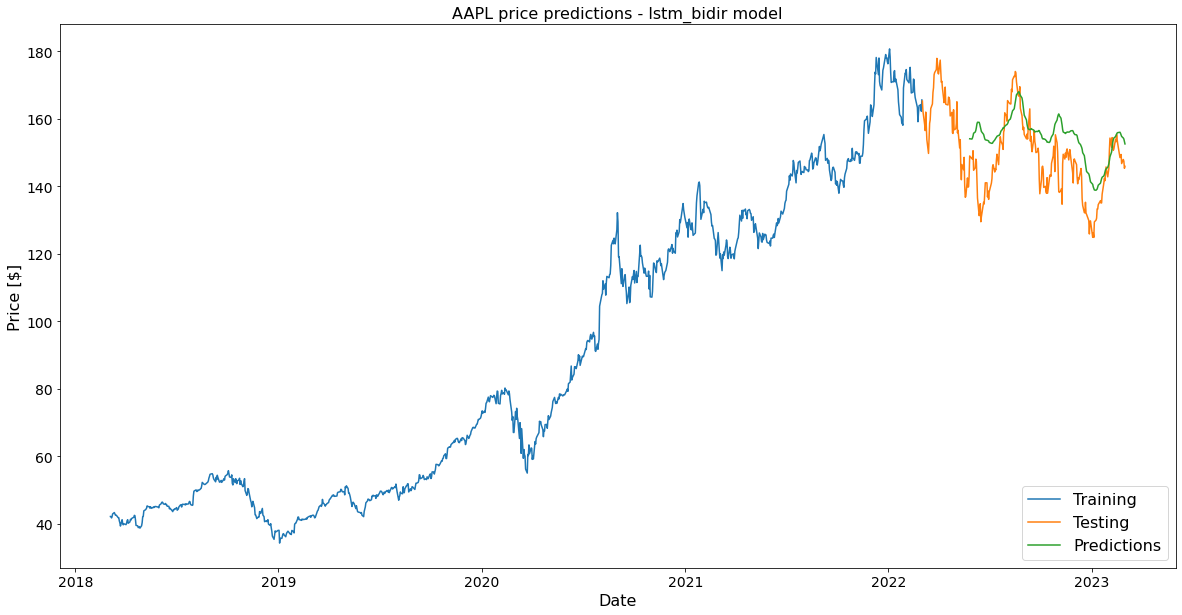

In [60]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## Deep bidirectional LSTM

### Settings

In [61]:
# General settings
run_model = ml_run_lstm_bidir_deep

In [62]:
# Training settings
model_name = 'lstm_bidir_deep'
train_model_flag = ml_train_flag
save_model_flag = ml_save_flag
load_model_flag = ml_load_flag
model_path = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 20
training_batch_size = 128
training_validation_split = 0.2
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 5)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [63]:
# Data settings
data_for_model = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
train_x = data_for_model['train']['features']
train_y = data_for_model['train']['targets']
test_x = data_for_model['test']['features']
test_y = data_for_model['test']['targets']
scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

if explore_data_flag:
    print('train_x.shape =', train_x.shape)
    print('train_y.shape =', train_y.shape)
    print('test_x.shape =', test_x.shape)
    print('test_y.shape =', test_y.shape)
    print()
    print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

train_x.shape = (947, 60, 1)
train_y.shape = (947, 1, 1)
test_x.shape = (191, 60, 1)
test_y.shape = (191, 1, 1)

test_x_unprocessed.shape = (191, 60, 1)


In [64]:
# Model settings
model = keras.Sequential([
    InputLayer(input_shape=(train_x.shape[1], train_y.shape[1])), # [(batch_size,) timesteps, features_dim]
    Bidirectional(LSTM(100, return_sequences=True)),
    Bidirectional(LSTM(100, return_sequences=False)),
    Dense(25, activation=None),
    Dropout(0.2),
    Dense(1, activation=None, name='output')
])

model.compile(
    optimizer = Adam(learning_rate=0.0003),
    loss='mean_squared_error',
    metrics = training_metrics,
    )

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 60, 200)          81600     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 25)                5025      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 327,451
Trainable params: 327,451
Non-tr

### Training

Epoch 1/20
6/6 [==============================] - 17s 1s/step - loss: 0.0726 - rmse: 0.2694 - val_loss: 0.0411 - val_rmse: 0.2028
Epoch 2/20
6/6 [==============================] - 3s 514ms/step - loss: 0.0144 - rmse: 0.1201 - val_loss: 0.0284 - val_rmse: 0.1687
Epoch 3/20
6/6 [==============================] - 3s 518ms/step - loss: 0.0101 - rmse: 0.1003 - val_loss: 0.0125 - val_rmse: 0.1120
Epoch 4/20
6/6 [==============================] - 3s 506ms/step - loss: 0.0064 - rmse: 0.0797 - val_loss: 0.0374 - val_rmse: 0.1934
Epoch 5/20
6/6 [==============================] - 7s 1s/step - loss: 0.0078 - rmse: 0.0885 - val_loss: 0.0123 - val_rmse: 0.1109
Epoch 6/20
6/6 [==============================] - 3s 493ms/step - loss: 0.0042 - rmse: 0.0650 - val_loss: 0.0023 - val_rmse: 0.0474
Epoch 7/20
6/6 [==============================] - 3s 507ms/step - loss: 0.0044 - rmse: 0.0667 - val_loss: 0.0020 - val_rmse: 0.0453
Epoch 8/20
6/6 [==============================] - 3s 508ms/step - loss: 0.0040 - 


Saved model to:
Models/model_lstm_bidir_deep_AAPL_1d/ 

Loaded model from:
Models/model_lstm_bidir_deep_AAPL_1d/ 

Presenting model summary:

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 60, 200)          81600     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 25)                5025      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 output (Dense)              (None, 1)     

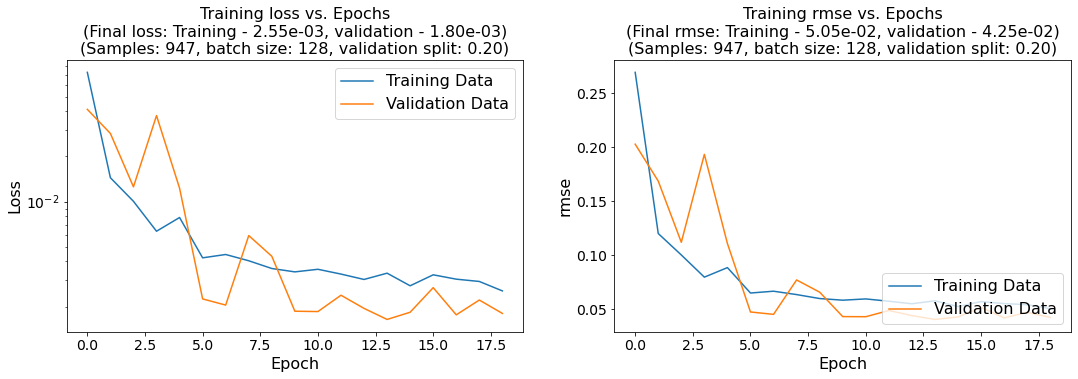

In [65]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        train_model_flag = train_model_flag,
        save_model_flag = save_model_flag,
        load_model_flag = load_model_flag,
        model_path = model_path,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating

6/6 [==============================] - 2s 54ms/step

Presenting evaluation metrics:

        model_name     mae    mape       mse     rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0  lstm_bidir_deep  8.8232  0.0621  115.2325  10.7346                    0.5323                 0.534                  0.5323               0.534                           0.4579                       0.4579                         0.4579                     0.4579 



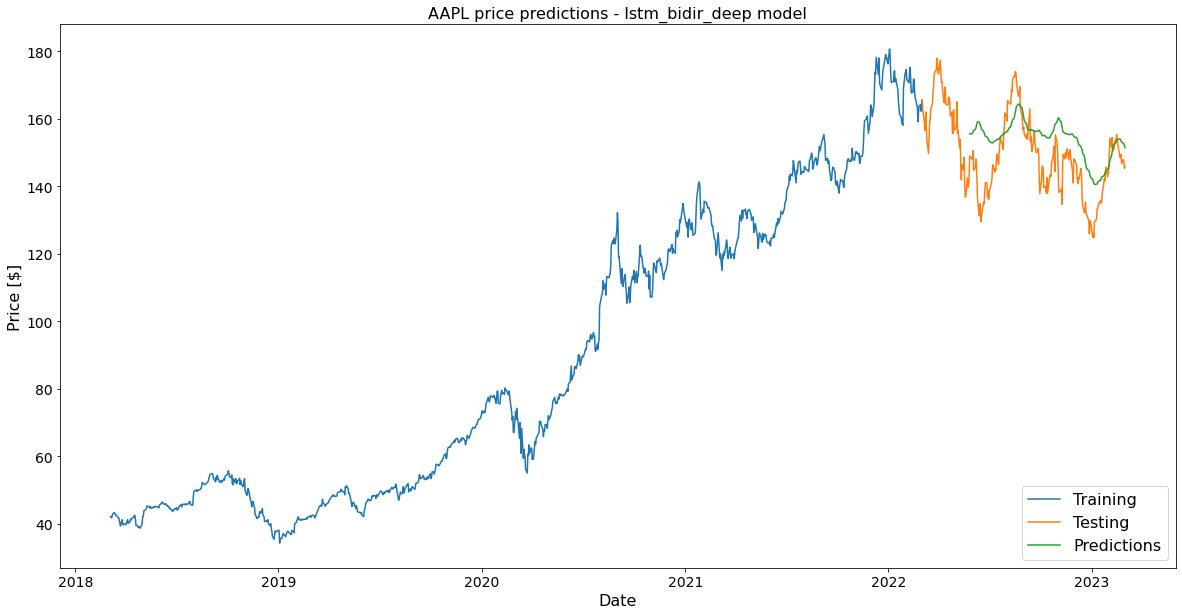

In [66]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## CNN LSTM

### Settings

In [67]:
# General settings
run_model = ml_run_lstm_cnn

In [68]:
# Training settings
model_name = 'lstm_cnn'
train_model_flag = ml_train_flag
save_model_flag = ml_save_flag
load_model_flag = ml_load_flag
model_path = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 20
training_batch_size = 128
training_validation_split = 0.2
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 5)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [69]:
# Data settings
data_for_model = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
train_x = data_for_model['train']['features']
train_y = data_for_model['train']['targets']
test_x = data_for_model['test']['features']
test_y = data_for_model['test']['targets']
scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

if explore_data_flag:
    print('train_x.shape =', train_x.shape)
    print('train_y.shape =', train_y.shape)
    print('test_x.shape =', test_x.shape)
    print('test_y.shape =', test_y.shape)
    print()
    print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

train_x.shape = (947, 60, 1)
train_y.shape = (947, 1, 1)
test_x.shape = (191, 60, 1)
test_y.shape = (191, 1, 1)

test_x_unprocessed.shape = (191, 60, 1)


In [70]:
# Model settings
num_samples_train = train_x.shape[0] # 947
num_samples_test = test_x.shape[0] # 191
num_time_steps_prices = train_x.shape[1] # 60
num_feats_per_time_step = train_x.shape[2] # 1

dropout_pct = 0.2

# Model inputs
model_input_prices = Input(shape=(num_time_steps_prices, num_feats_per_time_step))

# CNN
branch_prices = Conv1D(filters=32, kernel_size=3, activation='tanh', padding='same')(model_input_prices)
branch_prices = MaxPooling1D(pool_size=2, padding='same')(branch_prices)
branch_prices = Activation('relu')(branch_prices)
branch_prices = Dropout(dropout_pct)(branch_prices)

# LSTM
branch_prices = LSTM(units=64, return_sequences=False)(branch_prices)

# Model output
model_output = Dense(1, activation=None, name='output')(branch_prices)

# Defining the overall model
model = Model(inputs=model_input_prices, outputs=model_output)

model.compile(
    optimizer = Adam(learning_rate=0.0003),
    loss='mean_absolute_error',
    metrics = training_metrics,
    )

model.summary(show_trainable=True)

if run_model and save_model_flag:
    plot_path = model_path + f'model_{model_name}.png'
    plot_model(model,
               to_file = plot_path,
               show_shapes = True,
               expand_nested = True,
               show_layer_activations = True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_5 (InputLayer)        [(None, 60, 1)]           0         Y          
                                                                            
 conv1d (Conv1D)             (None, 60, 32)            128       Y          
                                                                            
 max_pooling1d (MaxPooling1D  (None, 30, 32)           0         Y          
 )                                                                          
                                                                            
 activation (Activation)     (None, 30, 32)            0         Y          
                                                                            
 dropout_1 (Dropout)         (None, 30, 32)            0         Y          
                                                             

### Training

Epoch 1/20
6/6 [==============================] - 7s 204ms/step - loss: 0.2052 - rmse: 0.2680 - val_loss: 0.5089 - val_rmse: 0.5138
Epoch 2/20
6/6 [==============================] - 0s 58ms/step - loss: 0.1239 - rmse: 0.1734 - val_loss: 0.3051 - val_rmse: 0.3099
Epoch 3/20
6/6 [==============================] - 0s 67ms/step - loss: 0.0619 - rmse: 0.0853 - val_loss: 0.0877 - val_rmse: 0.0970
Epoch 4/20
6/6 [==============================] - 0s 67ms/step - loss: 0.0533 - rmse: 0.0604 - val_loss: 0.0296 - val_rmse: 0.0382
Epoch 5/20
6/6 [==============================] - 0s 61ms/step - loss: 0.0443 - rmse: 0.0512 - val_loss: 0.0869 - val_rmse: 0.0953
Epoch 6/20
6/6 [==============================] - 0s 59ms/step - loss: 0.0353 - rmse: 0.0459 - val_loss: 0.1064 - val_rmse: 0.1133
Epoch 7/20
6/6 [==============================] - 0s 55ms/step - loss: 0.0304 - rmse: 0.0427 - val_loss: 0.0509 - val_rmse: 0.0609
Epoch 8/20
6/6 [==============================] - 0s 62ms/step - loss: 0.0243 - rm


Saved model to:
Models/model_lstm_cnn_AAPL_1d/ 

Loaded model from:
Models/model_lstm_cnn_AAPL_1d/ 

Presenting model summary:

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 60, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 32)           0         
 )                                                               
                                                                 
 activation (Activation)     (None, 30, 32)            0         
                                                                 
 dropout_1 (Dropout)         (None, 30, 32)            0         
                                                                

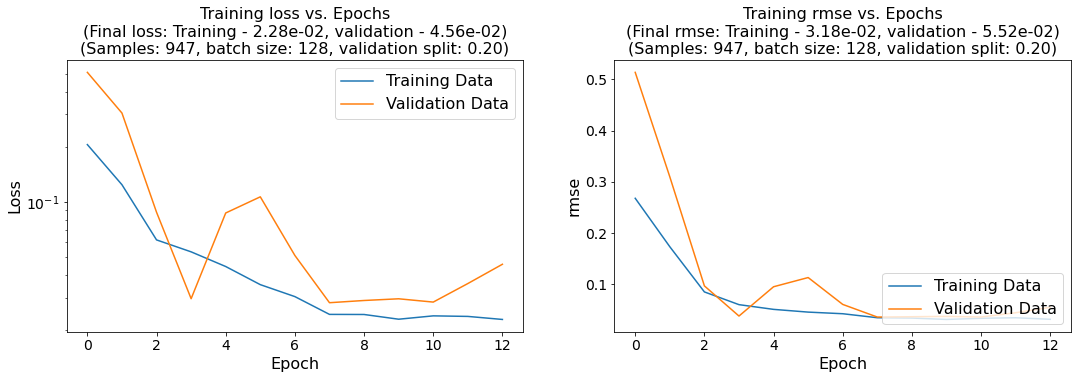

In [71]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        train_model_flag = train_model_flag,
        save_model_flag = save_model_flag,
        load_model_flag = load_model_flag,
        model_path = model_path,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating

6/6 [==============================] - 1s 11ms/step

Presenting evaluation metrics:

  model_name     mae   mape      mse    rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0   lstm_cnn  6.6314  0.046  63.2947  7.9558                    0.5175                0.5183                  0.5175              0.5183                           0.4789                       0.4789                         0.4789                     0.4789 



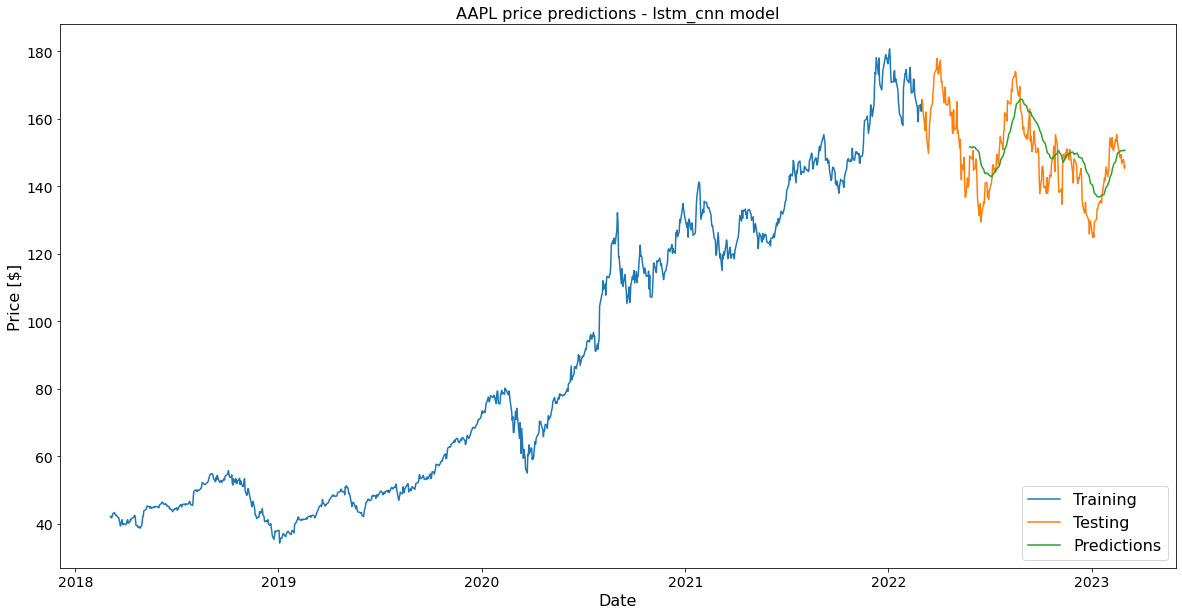

In [72]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## [TO-DO] CNN LSTM - prices & indicators

### Settings

In [73]:
# General settings
run_model = ml_run_lstm_cnn_prices_indics

In [74]:
# Training settings
model_name = 'lstm_cnn_prices_indics'
train_model_flag = ml_train_flag
save_model_flag = ml_save_flag
load_model_flag = ml_load_flag
model_path = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 20
training_batch_size = 128
training_validation_split = 0.2
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 5)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [75]:
# Data settings
data_for_model = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
train_x = data_for_model['train']['features']
train_y = data_for_model['train']['targets']
test_x = data_for_model['test']['features']
test_y = data_for_model['test']['targets']
scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

if explore_data_flag:
    print('train_x.shape =', train_x.shape)
    print('train_y.shape =', train_y.shape)
    print('test_x.shape =', test_x.shape)
    print('test_y.shape =', test_y.shape)
    print()
    print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

train_x.shape = (947, 60, 1)
train_y.shape = (947, 1, 1)
test_x.shape = (191, 60, 1)
test_y.shape = (191, 1, 1)

test_x_unprocessed.shape = (191, 60, 1)


In [76]:
# Model settings
num_samples_train = train_x.shape[0] # 947
num_samples_test = test_x.shape[0] # 191
num_time_steps_prices = train_x.shape[1] # 60
num_time_steps_indics = 60 # WIP
num_feats_per_time_step = train_x.shape[2] # 1

dropout_pct = 0.2

# Model inputs
model_input_prices = Input(shape=(num_time_steps_prices, num_feats_per_time_step))
model_input_indics = Input(shape=(num_time_steps_indics, num_feats_per_time_step))

# Prices branch
branch_prices = Conv1D(filters=32, kernel_size=3, activation='tanh', padding='same')(model_input_prices)
branch_prices = MaxPooling1D(2, padding='same')(branch_prices)
branch_prices = Dropout(dropout_pct)(branch_prices)

branch_prices = Bidirectional(LSTM(64, return_sequences=True))(branch_prices)
branch_prices = Dropout(dropout_pct)(branch_prices)
branch_prices = Bidirectional(LSTM(64, return_sequences=False))(branch_prices)

branch_prices = Model(inputs=model_input_prices, outputs=branch_prices)

# Indicators branch
branch_indics = Conv1D(filters=32, kernel_size=3, activation='tanh', padding='same')(model_input_indics)
branch_indics = MaxPooling1D(2, padding='same')(branch_indics)
branch_indics = Dropout(dropout_pct)(branch_indics)

branch_indics = Bidirectional(LSTM(64, return_sequences=True))(branch_indics)
branch_indics = Dropout(dropout_pct)(branch_indics)
branch_indics = Bidirectional(LSTM(64, return_sequences=False))(branch_indics)

branch_indics = Model(inputs=model_input_indics, outputs=branch_indics)

# Combining the branches
branch_combined = concatenate([branch_prices.output, branch_indics.output])
branch_combined = Dense(25, activation='linear')(branch_combined)
branch_combined = Dropout(dropout_pct)(branch_combined)

# Model output
model_output = Dense(1, activation='linear', name='output')(branch_combined)

# Defining the overall model
model = Model(inputs=[model_input_prices, model_input_indics], outputs=model_output)

model.compile(
    optimizer = Adam(learning_rate=0.0003),
    loss='mean_squared_error',
    metrics = training_metrics,
    )

model.summary(show_trainable=True)

if run_model and save_model_flag:
    plot_model(model,
               to_file = model_path + f'model_{model_name}.png',
               show_shapes = True,
               expand_nested = True,
               show_layer_activations = True)

Model: "model_3"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_6 (InputLayer)           [(None, 60, 1)]      0           []                               Y          
                                                                                                             
 input_7 (InputLayer)           [(None, 60, 1)]      0           []                               Y          
                                                                                                             
 conv1d_1 (Conv1D)              (None, 60, 32)       128         ['input_6[0][0]']                Y          
                                                                                                             
 conv1d_2 (Conv1D)              (None, 60, 32)       128         ['input_7[0][0]']                Y    

### Training

In [77]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = [train_x, train_x], # [train_x_prices, train_x_indics]
        # train_x = train_x_for_model, # Notice to modify shape for TimeDistributed
        train_y = train_y,

        train_model_flag = train_model_flag,
        save_model_flag = save_model_flag,
        load_model_flag = load_model_flag,
        model_path = model_path,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating

In [78]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model = model,
        model_name = model_name,
        test_x_unprocessed = [test_x_unprocessed, test_x_unprocessed],
        test_x = [train_x, train_x], # test_x_for_model, # Notice to modify shape for TimeDistributed
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

# Evaluation summary

In [79]:
# Summarizing models evaluation
eval_metrics_all = eval_metrics_all.reset_index(drop=True) \
    .sort_values('trend_end_bal_accuracy', ascending=False) \
    .sort_values('mse', ascending=True)

eval_metrics_all.to_csv(evaluation_saving_path) # Saving evaluation
print(f'Saving evaluations to:\n{evaluation_saving_path}\n')

display(eval_metrics_all)

Saving evaluations to:
Evaluations/evaluation_AAPL_1d_230306.csv



,model_name,mae,mape,mse,rmse,trend_start_bal_accuracy,trend_start_accuracy,trend_end_bal_accuracy,trend_end_accuracy,trend_consec_start_bal_accuracy,trend_consec_start_accuracy,trend_consec_end_bal_accuracy,trend_consec_end_accuracy
0,lstm_single,5.0271,0.0347,36.2635,6.0219,0.5075,0.5079,0.5075,0.5079,0.5000,0.5000,0.5000,0.5000
1,lstm_deep,6.2547,0.0430,53.6975,7.3279,0.5024,0.5026,0.5024,0.5026,0.5158,0.5158,0.5158,0.5158
4,lstm_cnn,6.6314,0.0460,63.2947,7.9558,0.5175,0.5183,0.5175,0.5183,0.4789,0.4789,0.4789,0.4789
2,lstm_bidir,8.6363,0.0609,109.3996,10.4594,0.5425,0.5445,0.5425,0.5445,0.4947,0.4947,0.4947,0.4947
3,lstm_bidir_deep,8.8232,0.0621,115.2325,10.7346,0.5323,0.5340,0.5323,0.5340,0.4579,0.4579,0.4579,0.4579
